### Notebook used to to measure collimation of the telescope using ATCollCam using the CWFS algorithm/package developed by Bo Xin.

#### Now using fork by David Thomas: https://github.com/davidthomas5412/cwfs 

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. 

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]


import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import copy
from pathlib import Path

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')
from scipy.signal import medfilt

In [2]:
#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

In [3]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

# declare Centroiding algorithm
def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [4]:
# This is just used to test the CofM algorithm.
def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

In [5]:
# Testing the CofM code
if False:
    center=(1400,750)
    stamp=make_circle((2500,1400), 100, center=center)

    calc_CofM(stamp)

    # Now try with subimage and reference to corner
    side=300
    guess_center = np.array((1550, 610))
    stamp2= stamp[guess_center[0]-side:guess_center[0]+side, 
                  guess_center[1]-side:guess_center[1]+side].copy()
    calc_CofM(stamp2, offset=(guess_center-side))

    if False:
        fig, ax = plt.subplots(figsize=(7,6))
        ax.imshow(stamp, interpolation='none')
        stamp.shape

        fig2, ax2 = plt.subplots(figsize=(7,6))
        ax2.imshow(stamp2, interpolation='none')
        stamp2.shape

In [7]:
from lsst.ts import salobj
import wget

In [9]:
d = salobj.Domain()
gencam = salobj.Remote(d, 'GenericCamera', index=1)
athexapod = salobj.Remote(d, 'ATHexapod')
await gencam.start_task
await athexapod.start_task

2020-01-09 00:25:04,911 GenericCamera INFO     Read historical data in 0.00 sec
2020-01-09 00:25:05,408 ATHexapod    INFO     Read historical data in 0.50 sec


In [10]:
gencam.cmd_setLogLevel.set(level=logging.DEBUG)
athexapod.cmd_setLogLevel.set(level=logging.DEBUG)

True

In [11]:
# Get summary state
print(salobj.State(gencam.evt_summaryState.get().summaryState))
print(salobj.State(athexapod.evt_summaryState.get().summaryState))

State.ENABLED
State.ENABLED


In [12]:
# Declare where data is located and where output will be written, notably the stacked images
data_folder = Path("/home/saluser/develop/ts_notebooks/pingraham/summit_notebooks/AT_20200108")
output_folder = Path("/home/saluser/data/output")

# Done with import and prep

In [15]:
# Print Hexapod Current position (given by last successful command)
curr_hex_pos = await athexapod.evt_positionUpdate.aget(timeout=10)
print('Hexapod position: \n x= {}, \n y= {}, \n z= {}, \n U= {}, \n V= {}'
      .format(curr_hex_pos.positionX, curr_hex_pos.positionY, curr_hex_pos.positionZ, curr_hex_pos.positionU, curr_hex_pos.positionV))

2020-01-09 00:58:27,557 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 100 messages
2020-01-09 00:58:27,690 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 100 messages


Hexapod position: 
 x= -4.30000051579, 
 y= 1.19998673396, 
 z= 0.499973673412, 
 U= 0.350001742999, 
 V= 0.219997034578


In [525]:
# Get current position by telemetry
# which is a list in X,Y,Z,U,V,Rot
await asyncio.sleep(1)
curr_hex__pos_telem = await athexapod.tel_positionStatus.next(flush = True, timeout=10)
print(curr_hex__pos_telem.reportedPosition)

2020-01-09 03:32:06,229 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 13 messages
2020-01-09 03:32:06,252 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 12 messages
2020-01-09 03:32:06,272 ATHexapod    WARNING  RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 12 messages


[-4.25000718731, 5.54933328164e-06, 0.465007072769, 0.34999904173, 0.220000066472, 2.43561624705e-06]


In [141]:
print()

In [643]:
# Move hexapod to desired starting position (in-focus) for acquisition in intra/extra focal images
# Note that minimal motions in X,Y,Z are ~0.3um (0.0003mm), so go to 4 decimal places
# minimal motions in U,V are ~3.5micro rads (0.0002 degrees), so go to 4 decimal places
# Rotation is not used
hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.29999921322-50e-3, 1.19999866188-1200e-3, 0.50000155519-35e-3, 0.3500006508, 0.219999852315, -2.69867951921e-07]

await athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                             z=hex_Z, u=hex_U, v=hex_V)

2020-01-09 03:55:35,416 ATHexapod    WARNING  RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 68 messages
2020-01-09 03:55:35,506 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 67 messages
2020-01-09 03:55:35,584 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 69 messages


In [644]:
await gencam.cmd_stopLiveView.start()

In [645]:
target_name='HIP24493'

## Get Intrafocal image

In [646]:
# Intrafocal hexapod setting - offsets -0.5mm from central focus value above
dz=1.5

await athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                             z=hex_Z-dz, u=hex_U, v=hex_V)

In [647]:
# r.evt_endReadout.flush()
expTime=20.0
await gencam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name)

tmp = await gencam.evt_endReadout.next(flush=False, timeout=1)
tmp = gencam.evt_endReadout.get()
print(tmp.imageName)

1578542143-HIP24493-0-1


In [648]:
wget_url = 'http://139.229.170.216:8000/data/'+tmp.imageName+'.fits'
#print(wget_url)
intra_fname = wget.download(wget_url)
print('Grabbed/Wrote intra-focal |image {} via wget'.format(intra_fname))

Grabbed/Wrote intra-focal |image 1578542143-HIP24493-0-1.fits via wget


## Get Extra-Focal Image

In [649]:
# Extrafocal hexapod setting
await athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                             z=hex_Z+dz, u=hex_U, v=hex_V)

In [650]:
# r.evt_endReadout.flush()
await gencam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name)

tmp = await gencam.evt_endReadout.next(flush=False, timeout=1)
tmp = gencam.evt_endReadout.get()
print(tmp.imageName)

1578542171-HIP24493-0-1


In [651]:
wget_url = 'http://139.229.170.216:8000/data/'+tmp.imageName+'.fits'
#print(wget_url)
extra_fname = wget.download(wget_url)
print('Grabbed/Wrote extra-focal image {} via wget'.format(extra_fname))

Grabbed/Wrote extra-focal image 1578542171-HIP24493-0-1.fits via wget


### Declare data directories and load intra/extra raw files

In [652]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(data_folder / intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(data_folder / extra_fname))[0].data

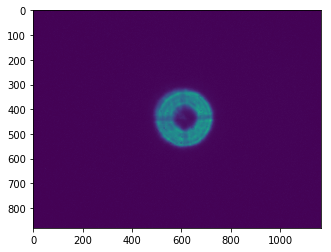

In [653]:
# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

### Grab centroid of images

In [654]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

3 -16
Creating stamps of centroid [y,x] = [434,608] with a side length of 150 pixels


In [655]:
np.median(im_filtered)

0.0

In [656]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

## Load instrument profile from "/home/saluser/develop/cwfs/data/auxtel"
### Make sure pixelSize and offset are correct for the dataset! 
### You *must* modify the file and not the loaded object!!!

In [657]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example


Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


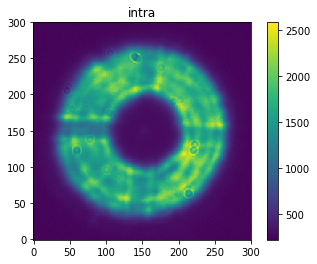

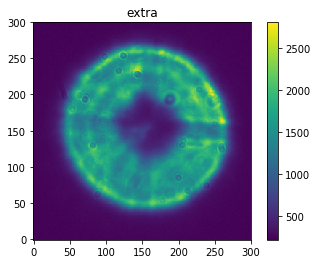

Extra-focal filename: 1578542171-HIP24493-0-1.fits
Intra-focal filename: 1578542143-HIP24493-0-1.fits


In [658]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

In [666]:

# Send hexapod back to focus to help target+offseting offseting efficiency
await athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                             z=hex_Z, u=hex_U, v=hex_V)

2020-01-09 04:00:12,974 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 100 messages
2020-01-09 04:00:13,235 ATHexapod    WARNING  RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 100 messages
2020-01-09 04:00:13,338 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 100 messages
2020-01-09 04:00:13,437 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 19 messages


In [659]:
# Calculate zernikes and wavefront
# Note that this will change I1 and I2!
# if you ever want to rerun this with different parameters you have to reload I1 and I2!
algo.runIt(inst,I1,I2,'onAxis')

In [660]:
#print zernikes
print(algo.zer4UpNm)

[-75.56096877 -89.50329108 -21.03519102  26.85118983  27.07089481
  19.45174871 -17.53832685  20.26453388  -6.90353258 -17.1768148
  16.45203786  -3.72883502  11.20361483  -4.64944306   9.10725486
  -5.25136482  -6.96382246   4.83055925 -13.44793738]


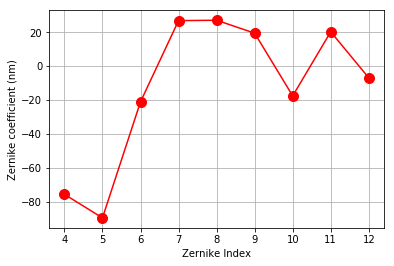

In [661]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

In [662]:
# plot the zernikes
#plots.plotZer(algo.zer4UpNm[0:9],'nm')

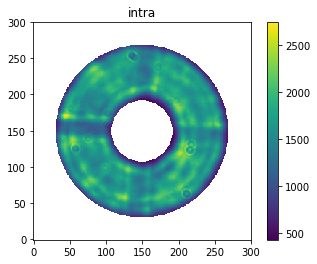

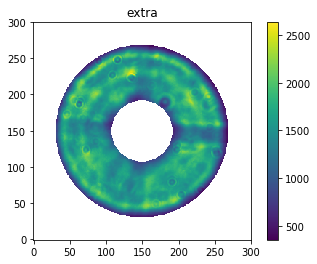

In [663]:
# Plot images with masks to check mapping is correct
# I think these plot residuals, but I1.image0 plots the original image
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)

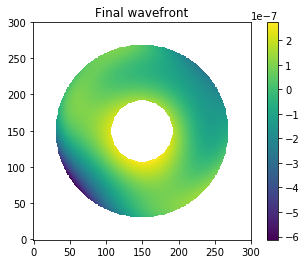

In [664]:
plots.plotImage(algo.Wconverge,'Final wavefront')

In [665]:
#plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

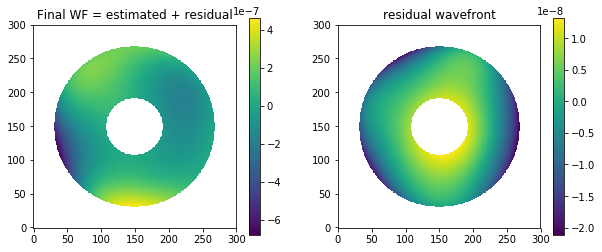

In [593]:
# Look at estimated wavefront and residual of wavefront that is not well fit
nanMask = np.ones(I1.image.shape)
nanMask[I1.pMask==0] = np.nan
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(algo.Wconverge*nanMask, origin='lower')
ax[0].set_title('Final WF = estimated + residual')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(algo.West*nanMask, origin='lower')
ax[1].set_title('residual wavefront')
fig.colorbar(img, ax=ax[1])

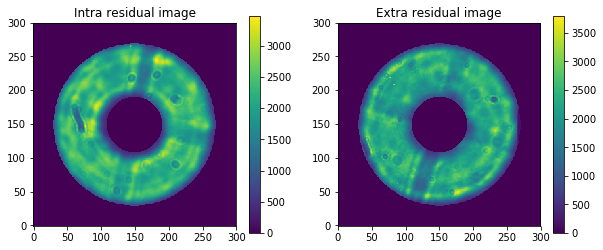

In [208]:
# Plot the residuals at each image - ideally they would be a constant
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(I1.image, origin='lower')
ax[0].set_title('Intra residual image')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(I2.image, origin='lower')
ax[1].set_title('Extra residual image')
fig.colorbar(img, ax=ax[1])

#### Now we do the forward raytrace using our wavefront solutions. The code is simply borrowed from existing cwfs code.

#### We first set up the pupil grid. Oversample means how many ray to trace from each grid point on the pupil.

In [209]:
oversample = 10
projSamples = I1.image0.shape[0]*oversample

luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

#### We now trace the rays to the image plane. Lutxp and Lutyp are image coordinates for each (oversampled) ray. showProjection() makes the intensity image. Then, to down sample the image back to original resolution, we want to use the function downResolution() which is defined for the image class.

In [210]:
lutxp, lutyp, J = aperture2image(I1, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I1fit = Image(show_lutxyp, fieldXY, Image.INTRA)
I1fit.downResolution(oversample, I1.image0.shape[0], I1.image0.shape[1])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Now do the same thing for extra focal image

In [ ]:
luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

lutxp, lutyp, J = aperture2image(I2, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I2fit = Image(show_lutxyp, fieldXY, Image.EXTRA)
I2fit.downResolution(oversample, I2.image0.shape[0], I2.image0.shape[1])

In [ ]:
#The atmosphere used here is just a random Gaussian smearing. We do not care much about the size at this point
from scipy.ndimage import gaussian_filter

I1fit.image[np.isnan(I1fit.image)]=0
a = gaussian_filter(I1fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I1fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Intra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(a, origin='lower')
ax[1].set_title('Forward prediction (w atm) Intra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I1.image0, origin='lower')
ax[2].set_title('Real Image, Intra')
fig.colorbar(img, ax=ax[2])

In [ ]:
I2fit.image[np.isnan(I2fit.image)]=0
b = gaussian_filter(I2fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I2fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Extra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(b, origin='lower')
ax[1].set_title('Forward prediction (w atm) Extra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I2.image0, origin='lower')
ax[2].set_title('Real Image, Extra')
fig.colorbar(img, ax=ax[2])